In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize,normalize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
from functools import reduce
from scipy.io import loadmat
from skimage.measure import block_reduce
from collections import Counter
from scipy.sparse import coo_matrix,hstack, vstack
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [18]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        trM.append(np.where(mask == 0.0, 0, 1)) #0, 1
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        teM.append(np.where(mask == 0.0, 0, 1))
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 90 seconds


In [19]:
class L2Normalization(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(L2Normalization, self).__init__()
        self.eps = 1e-8
        
    def forward(self, x):
        if x.is_cuda:
            caped_eps = Variable(torch.Tensor([self.eps])).cuda(torch.cuda.device_of(x).idx)
        else:
            caped_eps = Variable(torch.Tensor([self.eps]))
        x = torch.div(x.transpose(0,1),x.max(1)[0]).transpose(0,1) # max_normed
        norm = torch.norm(x,2,1) + caped_eps.expand(x.size()[0])
        y = torch.div(x.transpose(0,1),norm).transpose(0,1)
        return y
    
class RMAC(nn.Module):
    """
    Regional Maximum activation of convolutions (R-MAC).
    c.f. https://arxiv.org/pdf/1511.05879.pdf
    Args:
        level_n (int): number of levels for selecting regions.
    """
    def __init__(self,level_n:int):
        super(RMAC, self).__init__()
        self.first_show = True
        self.cached_regions = dict()
        self.level_n = level_n

    def _get_regions(self, h: int, w: int) -> List:
        """
        Divide the image into several regions.
        Args:
            h (int): height for dividing regions.
            w (int): width for dividing regions.
        Returns:
            regions (List): a list of region positions.
        """
        if (h, w) in self.cached_regions:
            return self.cached_regions[(h, w)]

        m = 1
        n_h, n_w = 1, 1
        regions = list()
        if h != w:
            min_edge = min(h, w)
            left_space = max(h, w) - min(h, w)
            iou_target = 0.4
            iou_best = 1.0
            while True:
                iou_tmp = (min_edge ** 2 - min_edge * (left_space // m)) / (min_edge ** 2)

                # small m maybe result in non-overlap
                if iou_tmp <= 0:
                    m += 1
                    continue

                if abs(iou_tmp - iou_target) <= iou_best:
                    iou_best = abs(iou_tmp - iou_target)
                    m += 1
                else:
                    break
            if h < w:
                n_w = m
            else:
                n_h = m

        for i in range(self.level_n):
            region_width = int(2 * 1.0 / (i + 2) * min(h, w))
            step_size_h = (h - region_width) // n_h
            step_size_w = (w - region_width) // n_w

            for x in range(n_h):
                for y in range(n_w):
                    st_x = step_size_h * x
                    ed_x = st_x + region_width - 1
                    assert ed_x < h
                    st_y = step_size_w * y
                    ed_y = st_y + region_width - 1
                    assert ed_y < w
                    regions.append((st_x, st_y, ed_x, ed_y))

            n_h += 1
            n_w += 1

        self.cached_regions[(h, w)] = regions
        return regions

    def forward(self, fea:torch.tensor) -> torch.tensor:
        final_fea = None
        if fea.ndimension() == 4:
            h, w = fea.shape[2:]       
            regions = self._get_regions(h, w)
            for _, r in enumerate(regions):
                st_x, st_y, ed_x, ed_y = r
                region_fea = (fea[:, :, st_x: ed_x, st_y: ed_y].max(dim=3)[0]).max(dim=2)[0]#max-pooling
                region_fea = region_fea / torch.norm(region_fea, dim=1, keepdim=True)#PCA-whitening
                if final_fea is None:
                    final_fea = region_fea
                else:
                    final_fea = final_fea + region_fea
        else:# In case of fc feature.
            assert fea.ndimension() == 2
            if self.first_show:
                print("[RMAC Aggregator]: find 2-dimension feature map, skip aggregation")
                self.first_show = False
            final_fea = fea
        return final_fea

In [20]:
#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class NNet(nn.Module):
    def __init__(self, block, num_blocks=[2,2,2,2], n_classes=2, code_size=64):
        super(NNet, self).__init__()
        # Bottom-up layers，classifcation loss
        self.in_planes = 8  #3 D->64 channels
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        self.layer2 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer3 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer4 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer5 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(256, 32, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(32*4*4, code_size)#code_size:length of hash code
        self.fc2 = nn.Linear(code_size, n_classes) #num_classes:number of classes
        
        # Top-down layer, segmentation loss
        self.toplayer = nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0)  # Reduce channels
        
        self.latlayer1 = nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0)# Lateral layers
        self.latlayer2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        
        self.upsample = nn.Upsample((256,256), mode='bilinear',align_corners=True)
        self.conv7 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2)#mask 0,1,2
        
        # Hash layer, ranking loss
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.r_mac_pool = RMAC(level_n=3) 
        self.l2norm = L2Normalization()
        self.fc3 = nn.Linear(512, n_classes) #num_classes:number of classes

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up, classifcation loss
        h1 = F.relu(self.bn1(self.conv1(x)))#(3,256,256)->(8,128,128)
        h1 = F.max_pool2d(h1, kernel_size=3, stride=2, padding=1)#(8,128,128)->(8,64,64)
        
        h2 = self.layer2(h1)#(8,64,64)->(32,64,64)
        h3 = self.layer3(h2)#(32,64,64)->(64,32,32)
        h4 = self.layer4(h3)#(64,32,32)->(128,16,16)
        h5 = self.layer5(h4)#(128,16,16)->(256,8,8)
        
        h6 = self.conv6(h5)#(256,8,8)->(32,4,4) 
        h6 = h6.view(h6.size(0), -1)#conv->linear
        h_feat = self.fc1(h6)
        h_cls = self.fc2(h_feat)
        
        # Top-down, segmentation loss
        s5 = self.toplayer(h5)#(256,8,8)->(32,8,8)
        s4 = self._upsample_add(s5, self.latlayer1(h4))#{(32,8,8),(32, 16, 16)}->(32, 16, 16)
        s3 = self._upsample_add(s4, self.latlayer2(h3))#{(32, 16, 16),(32, 32, 32)}->(32, 32, 32)
        s2 = self._upsample_add(s3, h2) #{(32, 32, 32),(32, 64, 64)}->(32, 64, 64)
        
        s1 = self.upsample(s2)#(32, 64, 64)->(32, 256, 256)
        s_mask = self.bn2(self.conv7(s1))#(32, 256, 256)->(2, 256, 256)
        
        #Hash, ranking loss
        c5 = self.conv8(h5)#(256,8,8)->(512,8,8)
        
        c4 = self.r_mac_pool(c5) 
        
        c_feat = self.l2norm(c4) #512
        c_cls = self.fc3(c_feat)

        return h_feat, h_cls, s_mask, c_feat, c_cls

In [21]:
net = NNet(block=Bottleneck)
fms = net(Variable(torch.randn(10,3,256,256)))
for fm in fms:
    print(fm.size())

/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 64])
torch.Size([10, 2])
torch.Size([10, 2, 256, 256])
torch.Size([10, 512])
torch.Size([10, 2])


In [49]:
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    trQ_m, trP_m, trN_m = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        trQ_m.append(trM[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y), np.array(trQ_m), np.array(trP_m), np.array(trN_m)
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y, trQ_m, trP_m, trN_m = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (trQ_m.shape==trP_m.shape and trQ_m.shape==trN_m.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = NNet(block=Bottleneck).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes #F.log_softmax+F.nll_loss
#mse_loss  = nn.MSELoss().cuda() #define mseloss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_q_m = trQ_m[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_p_m = trP_m[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    train_n_m = trN_m[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        Q_m_batch = torch.from_numpy(train_q_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_m_batch = torch.from_numpy(train_p_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_m_batch = torch.from_numpy(train_n_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_h_feat, Q_h_cls, Q_s_mask, Q_c_feat, Q_c_cls = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_h_feat, P_h_cls, P_s_mask, P_c_feat, P_c_cls = model(P_batch.permute(0, 3, 1, 2))
        N_h_feat, N_h_cls, N_s_mask, N_c_feat, N_c_cls = model(N_batch.permute(0, 3, 1, 2))
        #loss
        #rank_loss = tl_loss(Q_h_feat, P_h_feat, N_h_feat)
        #rank_loss.backward(retain_graph=True)
        mask_loss = ce_loss(Q_s_mask,Q_m_batch) + ce_loss(P_s_mask,P_m_batch) + ce_loss(N_s_mask,N_m_batch)
        mask_loss.backward()#buffer  #retain_graph=True
        #cls_loss = ce_loss(Q_c_cls,Q_y_batch) + ce_loss(P_c_cls,P_y_batch) + ce_loss(N_c_cls,N_y_batch) 
        #cls_loss = ce_loss(Q_h_cls,Q_y_batch) + ce_loss(P_h_cls,P_y_batch) + ce_loss(N_h_cls,N_y_batch) 
        #cls_loss.backward() 
        optimizer.step()#update parameters
        #show loss
        loss = mask_loss #mask_loss + cls_loss 
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#model = model.cpu()#release gpu memory
#torch.cuda.empty_cache()

#hash code of train data 
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_cls, x_mask, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

 328 / 328 : loss = 1.055684Eopch:     1 mean_loss = 1.498614
 328 / 328 : loss = 0.814326Eopch:     2 mean_loss = 0.977438
 328 / 328 : loss = 0.577727Eopch:     3 mean_loss = 0.703845
 328 / 328 : loss = 0.483974Eopch:     4 mean_loss = 0.531752
 328 / 328 : loss = 0.369575Eopch:     5 mean_loss = 0.423379
 328 / 328 : loss = 0.329862Eopch:     6 mean_loss = 0.354145
 328 / 328 : loss = 0.274311Eopch:     7 mean_loss = 0.299576
 328 / 328 : loss = 0.322315Eopch:     8 mean_loss = 0.254130
 328 / 328 : loss = 0.237778Eopch:     9 mean_loss = 0.225215
 328 / 328 : loss = 0.195779Eopch:    10 mean_loss = 0.198709
best_loss = 0.198709
 36 / 37 8 Completed buliding index in 1 seconds
mAP@5=0.4710
mAP@10=0.4272
mAP@20=0.3986
mAP@50=0.3649
mIoU=0.9609
Accuracy: 0.468493


In [48]:
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
Q_batch = Q_batch.cpu()
Q_y_batch = Q_y_batch.cpu()
P_batch = P_batch.cpu()
P_y_batch = P_y_batch.cpu()
N_batch = N_batch.cpu()
N_y_batch = N_y_batch.cpu()
torch.cuda.empty_cache()

Counter({0: 62135, 1: 3401})


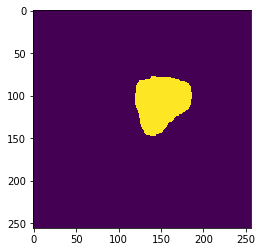

In [17]:
mask_path= '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/6818.PNG'
mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255
mask = np.where(mask == 0.0, 0, 1)
print(Counter(mask.flatten()))
plt.imshow(mask)
plt.show()

In [68]:
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.transpose(np.array(teM_pred[i]),(1,2,0))
    iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

mIoU=0.6459
Accuracy: 0.463014


(-0.5, 807.5, 556.5, -0.5)

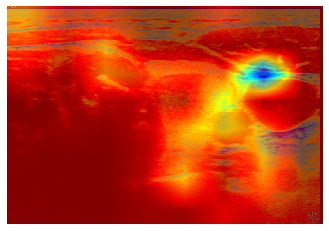

In [36]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

#original
image_path='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/'+teN[0]
#image_path ='/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+teN[0]
oriImg = cv2.imread(image_path)
oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)
#cv2.IMREAD_GRAYSCALE,mpimg.imread(image_path),cv2.imread(image_path)
#oriImg = cv2.resize(mpimg.imread(image_path), (256, 256))
#oriImg = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/343.mat')['mask']
#print(Counter(oriImg.flatten()))
#plt.imshow(oriImg)
#plt.axis('off')

#train
data = torch.from_numpy(np.array(teI[0:1])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.layer5.register_forward_hook(get_activation('layer5'))#maxpool
feature = activation['layer5'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width = oriImg.shape[0],oriImg.shape[1]
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
overlay_img = cv2.addWeighted(oriImg,0.3,featuremap,0.7,0)
plt.imshow(overlay_img)
plt.axis('off')

Counter({0.0: 192576, 1.0: 3852, 0.984375: 18, 0.421875: 15, 0.765625: 6, 0.015625: 6, 0.1642456: 3, 0.45703125: 3, 0.49945068: 3, 0.4673462: 3, 0.36187744: 3, 0.022155762: 3, 0.77752686: 3, 0.890625: 3, 0.98046875: 3, 0.98931885: 3, 0.1449585: 3, 0.48828125: 3, 0.9990845: 3, 0.4824829: 3, 0.08929443: 3, 0.171875: 3, 0.98480225: 3, 0.61505127: 3, 0.41680908: 3, 0.796875: 3, 0.015075684: 3, 0.66693115: 3, 0.5050659: 3, 0.609375: 3, 0.96795654: 3, 0.27215576: 3, 0.29901123: 3, 0.953125: 3, 0.004333496: 3, 0.4208374: 3, 0.7116089: 3, 0.45941162: 3, 0.203125: 3, 0.94366455: 3, 0.17120361: 3, 0.82147217: 3, 0.578125: 3, 0.7789917: 3, 0.734375: 3, 0.80133057: 3, 0.6017456: 3, 0.93011475: 3, 0.014831543: 3, 0.7296753: 3, 0.08984375: 3})
4032
192576


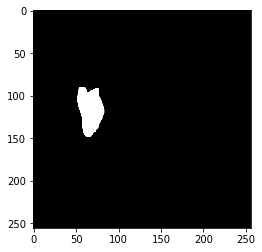

In [6]:
from collections import Counter
print(Counter(np.array(trM[0]).flatten()))
pred_inds = trM[0]!= 0
pred_sum = pred_inds.sum()
print (pred_sum)
pred_inds = trM[0]== 0
pred_sum = pred_inds.sum()
print (pred_sum)
imgplot = plt.imshow(trM[0])
plt.show()

(642, 920)


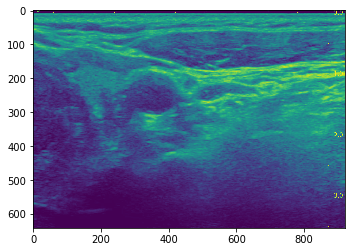

In [11]:
img=mpimg.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/'+trN[0])
print (img.shape)
imgplot = plt.imshow(img)
plt.show()

(642, 920)


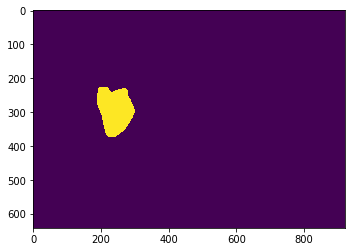

In [12]:
img=mpimg.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+trN[0])
print (img.shape)
imgplot = plt.imshow(img)
plt.show()

1


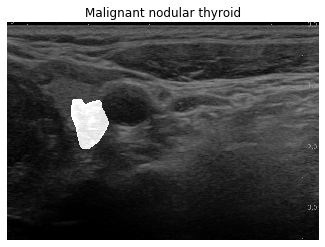

In [12]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/'+trN[0])
overlay = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/'+trN[0])
print(trY[0])
# Help please
added_image = cv2.addWeighted(background,0.6,overlay,0.8,0)
#added_image = cv2.bitwise_and(background, overlay)
#cv2.imwrite('combined.png', added_image)
#cv2.imshow("Image", added_image)
plt.axis('off')
plt.title('Malignant nodular thyroid' )
plt.imshow(added_image)
plt.show()

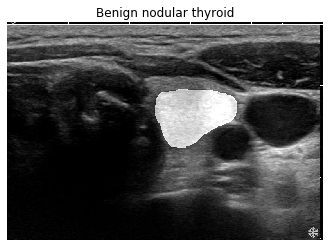

In [73]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/6818.PNG')
overlay = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/6818.PNG')
#print(trY[0])
# Help please
added_image = cv2.addWeighted(background,1.0,overlay,0.6,0)
#added_image = cv2.bitwise_and(background, overlay)
#cv2.imwrite('combined.png', added_image)
#cv2.imshow("Image", added_image)
plt.axis('off')
plt.title('Benign nodular thyroid' )
plt.imshow(added_image)
plt.show()

In [31]:
#compute the size of lesion
def Func_IOU_size(pred,target):
    '''
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
    '''
    pred_inds = pred != 0
    target_inds = target != 0
    i_sum = pred_inds==target_inds
    intersection_sum = i_sum.sum()
    union_sum = pred_inds.sum() + target_inds.sum() - i_sum.sum()
    iou = round(float(intersection_sum/union_sum))
    return iou
    
def compute_iou(rec1, rec2):
    """
    computing IoU
    :param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    :param rec2: (y0, x0, y1, x1)
    :return: scala value of IoU
    """
    # computing area of each rectangles
    S_rec1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    S_rec2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])
 
    # computing the sum_area
    sum_area = S_rec1 + S_rec2
 
    # find the each edge of intersect rectangle
    left_line = max(rec1[1], rec2[1])
    right_line = min(rec1[3], rec2[3])
    top_line = max(rec1[0], rec2[0])
    bottom_line = min(rec1[2], rec2[2])
 
    # judge if there is an intersect
    if left_line >= right_line or top_line >= bottom_line:
        return 0
    else:
        intersect = (right_line - left_line) * (bottom_line - top_line)
        
for i in range(len(teF)):       
    scores, neighbors = gpu_index.search(np.array(teF[i:i+1]).astype('float32'), k=5)
    print(scores)
    print(teN[i]+'<->'+str(teY[i]))
    for j in neighbors[0].tolist():
        print(trN[j]+'<->'+str(trY[j]))

[[112.36328 117.5791  127.60498 134.13037 139.11572]]
6818.PNG<->0
9306.PNG<->1
8624.PNG<->1
4269.PNG<->1
3340.PNG<->1
9202.PNG<->1
[[118.34888 118.69287 135.25928 137.18372 144.36572]]
5172.PNG<->0
8486.PNG<->1
2113.PNG<->1
9474.PNG<->1
3388.PNG<->1
4106.PNG<->1
[[127.57678 151.03589 160.19751 167.94916 171.76782]]
439.PNG<->0
5844.PNG<->0
1122.PNG<->0
6620.PNG<->0
541.PNG<->0
988.PNG<->0
[[ 85.46991  87.07117 104.0011  107.20596 111.69348]]
9312.PNG<->1
4165.PNG<->1
4725.PNG<->1
7644.PNG<->1
9324.PNG<->1
2070.PNG<->1
[[ 72.28731  82.87991 101.32985 101.92785 109.05066]]
5308.PNG<->0
9593.PNG<->1
9268.PNG<->1
8815.PNG<->1
2280.PNG<->1
8162.PNG<->1
[[ 74.44586   83.810425 111.38092  118.17444  118.43158 ]]
384.PNG<->0
8846.PNG<->1
3151.PNG<->1
8022.PNG<->1
2373.PNG<->1
9717.PNG<->1
[[ 84.545975  92.80313  109.91283  115.89404  121.185425]]
8389.PNG<->1
8815.PNG<->1
9268.PNG<->1
2636.PNG<->1
4528.PNG<->1
9637.PNG<->1
[[67.93878  73.05362  74.781555 80.73563  85.83569 ]]
7772.PNG<->1
237

[[ 84.53394 104.29814 109.00989 133.73029 137.3709 ]]
2798.PNG<->1
8408.PNG<->1
9232.PNG<->1
8821.PNG<->1
215.PNG<->0
1148.PNG<->0
[[111.91536 134.44081 139.92024 143.81897 144.95752]]
6804.PNG<->0
4053.PNG<->1
2434.PNG<->1
3721.PNG<->1
6580.PNG<->0
9308.PNG<->1
[[ 87.073    106.09924  114.940796 117.9043   119.83887 ]]
686.PNG<->0
1572.PNG<->0
207.PNG<->0
7157.PNG<->0
6705.PNG<->0
7222.PNG<->0
[[123.91321  124.661255 127.2677   129.69948  135.1864  ]]
8550.PNG<->1
8773.PNG<->1
6193.PNG<->0
990.PNG<->0
9759.PNG<->1
5686.PNG<->0
[[117.58215 138.41766 150.33057 151.81512 153.13477]]
1837.PNG<->0
1823.PNG<->0
541.PNG<->0
5458.PNG<->0
345.PNG<->0
6620.PNG<->0
[[ 90.49878   91.085815  93.09961   94.644775 102.79224 ]]
8915.PNG<->1
3235.PNG<->1
8238.PNG<->1
7842.PNG<->1
3191.PNG<->1
2152.PNG<->1
[[288.6328  304.4082  458.83594 473.292   505.71387]]
100.PNG<->0
1726.PNG<->0
5799.PNG<->0
1595.PNG<->0
559.PNG<->0
5496.PNG<->0
[[ 89.40329   91.199715 102.41839  104.97767  115.055176]]
4442.PNG<-

[[220.70117 241.16138 249.05762 270.65576 275.9878 ]]
402.PNG<->0
525.PNG<->0
5545.PNG<->0
414.PNG<->0
7057.PNG<->0
5218.PNG<->0
[[125.41101 152.0199  153.63055 163.4386  177.0589 ]]
4614.PNG<->1
9460.PNG<->1
2070.PNG<->1
9172.PNG<->1
4285.PNG<->1
8890.PNG<->1
[[101.81506  109.18799  110.593506 112.37451  113.34863 ]]
3159.PNG<->1
1851.PNG<->0
5396.PNG<->0
682.PNG<->0
5609.PNG<->0
7146.PNG<->0
[[ 23.097168 109.30127  110.043335 111.47864  113.09363 ]]
659.PNG<->0
5615.PNG<->0
1034.PNG<->0
6145.PNG<->0
890.PNG<->0
5472.PNG<->0
[[122.6732  128.67084 149.16553 159.3926  161.64966]]
3780.PNG<->1
8060.PNG<->1
7089.PNG<->0
6653.PNG<->0
4656.PNG<->1
8809.PNG<->1
[[ 80.715576  81.779175  93.19458   97.0661   101.053345]]
8667.PNG<->1
2082.PNG<->1
2365.PNG<->1
9615.PNG<->1
8699.PNG<->1
4472.PNG<->1
[[ 27.41333 120.70337 127.5166  130.17334 132.35889]]
2541.PNG<->1
2552.PNG<->1
3418.PNG<->1
4335.PNG<->1
9240.PNG<->1
8999.PNG<->1
[[193.84802 211.43921 222.74805 225.50415 226.77411]]
8649.PNG<->1


[[201.68787 222.93103 264.3203  265.18823 274.45038]]
6798.PNG<->0
670.PNG<->0
1040.PNG<->0
1581.PNG<->0
370.PNG<->0
974.PNG<->0
[[91.23328  92.15454  95.43848  95.51404  96.461914]]
3693.PNG<->1
7312.PNG<->0
7292.PNG<->0
882.PNG<->0
5613.PNG<->0
6043.PNG<->0
[[ 67.43335  105.558105 106.56885  107.99634  108.45166 ]]
4518.PNG<->1
2136.PNG<->1
9520.PNG<->1
4474.PNG<->1
3459.PNG<->1
8343.PNG<->1
[[ 10.970215  85.10101  101.62109  102.87982  103.06714 ]]
5617.PNG<->0
661.PNG<->0
1168.PNG<->0
1492.PNG<->0
1688.PNG<->0
7166.PNG<->0
[[109.55658 128.54608 130.73877 131.43195 147.45374]]
2422.PNG<->1
1992.PNG<->1
2124.PNG<->1
4456.PNG<->1
2035.PNG<->1
8556.PNG<->1
[[110.817314 125.13421  129.83502  130.31479  131.70323 ]]
7117.PNG<->0
2453.PNG<->1
4478.PNG<->1
3026.PNG<->1
4283.PNG<->1
8536.PNG<->1
[[133.29208 141.42389 152.37997 153.81815 156.08731]]
3173.PNG<->1
5869.PNG<->0
1540.PNG<->0
7276.PNG<->0
876.PNG<->0
8221.PNG<->1
[[ 94.192474  97.58627  107.40816  109.73682  114.27069 ]]
4552.PNG

[[189.29077 224.72192 228.23584 229.51355 243.49365]]
163.PNG<->0
6513.PNG<->0
6413.PNG<->0
5440.PNG<->0
5946.PNG<->0
38.PNG<->0
[[136.36005 137.21356 144.09088 144.71588 158.97766]]
9132.PNG<->1
9717.PNG<->1
9254.PNG<->1
3675.PNG<->1
4487.PNG<->1
8783.PNG<->1
[[69.96942  74.17795  79.134796 80.49005  81.45926 ]]
7169.PNG<->0
4978.PNG<->0
7235.PNG<->0
1349.PNG<->0
7166.PNG<->0
990.PNG<->0
[[105.59741 111.06369 112.45177 133.89441 135.10544]]
3563.PNG<->1
4101.PNG<->1
9538.PNG<->1
2043.PNG<->1
4398.PNG<->1
7698.PNG<->1
[[149.25111 159.67403 161.18604 166.40347 170.14894]]
9004.PNG<->1
9027.PNG<->1
4283.PNG<->1
8536.PNG<->1
7563.PNG<->1
2920.PNG<->1
[[105.42157 106.54413 116.94745 120.97836 125.38495]]
1125.PNG<->0
7166.PNG<->0
376.PNG<->0
1823.PNG<->0
7187.PNG<->0
6705.PNG<->0
[[108.84092 131.47998 134.67908 158.91109 160.39355]]
2451.PNG<->1
7281.PNG<->0
4053.PNG<->1
6580.PNG<->0
9308.PNG<->1
5448.PNG<->0
[[164.05579 167.76166 172.53381 179.77841 189.93826]]
4317.PNG<->1
9232.PNG<->1
7

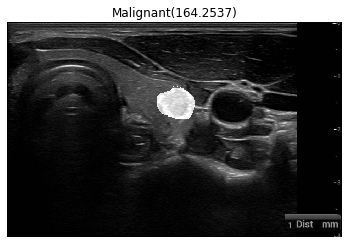

In [37]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/image/8221.PNG')
overlay = cv2.imread('/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/mask/8221.PNG')
#print(trY[0])
# Help please
added_image = cv2.addWeighted(background,1.0,overlay,0.6,0)
#added_image = cv2.bitwise_and(background, overlay)
#cv2.imwrite('combined.png', added_image)
#cv2.imshow("Image", added_image)
plt.axis('off')
#plt.title('Malignant nodular thyroid' )
plt.title('Malignant(164.2537)' )
plt.imshow(added_image)
plt.show()